# Algorithmic Trading

In [ ]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import zipfile

# Extract and load dataset
zip_file_path = 'Cryptocurrency Historical Data.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current directory

# Load the dataset
data_path = 'consolidated_coin_data.csv'
crypto_data = pd.read_csv(data_path)

# Display the first few rows of the data
print("\nCryptocurrency Data (First 5 Rows):")
print(crypto_data.head())


Cryptocurrency Data (First 5 Rows):
  Currency          Date  Open  High   Low Close      Volume   Market Cap
0    tezos  Dec 04, 2019  1.29  1.32  1.25  1.25  46,048,752  824,588,509
1    tezos  Dec 03, 2019  1.24  1.32  1.21  1.29  41,462,224  853,213,342
2    tezos  Dec 02, 2019  1.25  1.26  1.20  1.24  27,574,097  817,872,179
3    tezos  Dec 01, 2019  1.33  1.34  1.25  1.25  24,127,567  828,296,390
4    tezos  Nov 30, 2019  1.31  1.37  1.31  1.33  28,706,667  879,181,680


In [3]:
# Data Cleaning and Preprocessing

# Check for missing values
print("\nMissing Values in Cryptocurrency Data:")
print(crypto_data.isnull().sum())

# Convert 'Volume' and 'Market Cap' columns to numeric (remove commas, if any)
crypto_data['Volume'] = crypto_data['Volume'].replace({',': ''}, regex=True).astype(float)
crypto_data['Market Cap'] = crypto_data['Market Cap'].replace({',': ''}, regex=True).astype(float)

# Convert Date column to datetime
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'], format='%b %d, %Y')  # Ensure format consistency

# Drop rows with missing values or handle missing values as needed
crypto_data.dropna(inplace=True)

# Inspect data types and ensure correct formatting
print("\nData Types After Cleaning:")
print(crypto_data.dtypes)

# Display first few rows after cleaning
print("\nCleaned Cryptocurrency Data (First 5 Rows):")
print(crypto_data.head())


Missing Values in Cryptocurrency Data:
Currency      0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

Data Types After Cleaning:
Currency              object
Date          datetime64[ns]
Open                  object
High                  object
Low                   object
Close                 object
Volume               float64
Market Cap           float64
dtype: object

Cleaned Cryptocurrency Data (First 5 Rows):
  Currency       Date  Open  High   Low Close      Volume   Market Cap
0    tezos 2019-12-04  1.29  1.32  1.25  1.25  46048752.0  824588509.0
1    tezos 2019-12-03  1.24  1.32  1.21  1.29  41462224.0  853213342.0
2    tezos 2019-12-02  1.25  1.26  1.20  1.24  27574097.0  817872179.0
3    tezos 2019-12-01  1.33  1.34  1.25  1.25  24127567.0  828296390.0
4    tezos 2019-11-30  1.31  1.37  1.31  1.33  28706667.0  879181680.0



Data Types After Cleaning:
Currency              object
Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

Cleaned Cryptocurrency Data (First 5 Rows):
  Currency       Date  Open  High   Low  Close      Volume   Market Cap
0    tezos 2019-12-04  1.29  1.32  1.25   1.25  46048752.0  824588509.0
1    tezos 2019-12-03  1.24  1.32  1.21   1.29  41462224.0  853213342.0
2    tezos 2019-12-02  1.25  1.26  1.20   1.24  27574097.0  817872179.0
3    tezos 2019-12-01  1.33  1.34  1.25   1.25  24127567.0  828296390.0
4    tezos 2019-11-30  1.31  1.37  1.31   1.33  28706667.0  879181680.0


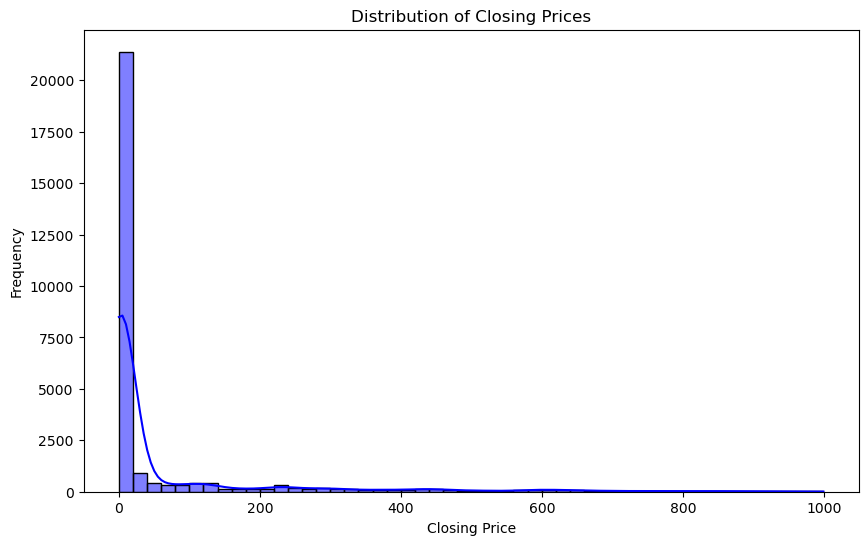

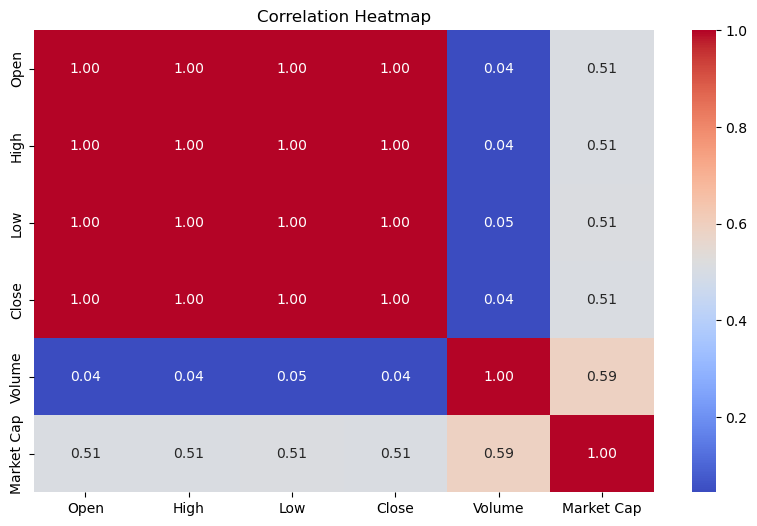

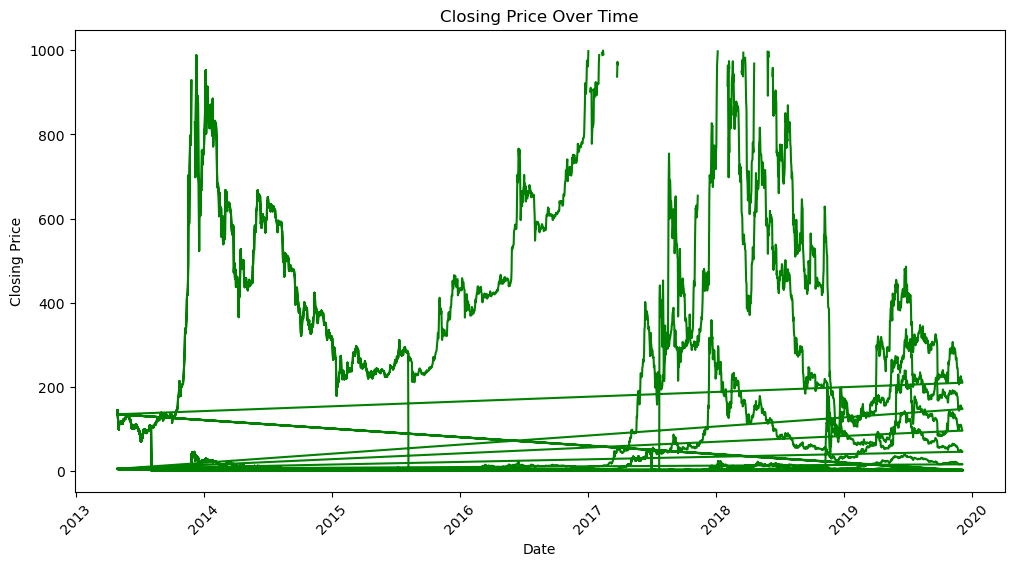

In [5]:
# Exploratory Data Analysis (EDA)

# Remove commas and convert to float
crypto_data['Volume'] = crypto_data['Volume'].replace({',': ''}, regex=True).astype(float)
crypto_data['Market Cap'] = crypto_data['Market Cap'].replace({',': ''}, regex=True).astype(float)

# Ensure the 'Close', 'Open', 'High', and 'Low' columns are also numeric
crypto_data[['Open', 'High', 'Low', 'Close']] = crypto_data[['Open', 'High', 'Low', 'Close']].apply(pd.to_numeric, errors='coerce')

# Now check the data types again
print("\nData Types After Cleaning:")
print(crypto_data.dtypes)

# Inspect cleaned data
print("\nCleaned Cryptocurrency Data (First 5 Rows):")
print(crypto_data.head())

# Plot distribution of the closing prices
plt.figure(figsize=(10, 6))
sns.histplot(crypto_data['Close'], kde=True, color='blue', bins=50)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap to check relationships between numerical features
crypto_data_corr = crypto_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(crypto_data_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(crypto_data['Date'], crypto_data['Close'], color='green')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Feature Engineering

# Create daily returns based on closing price
crypto_data['Daily Return'] = crypto_data['Close'].pct_change()

# Create moving averages (e.g., 7-day, 30-day)
crypto_data['7-day MA'] = crypto_data['Close'].rolling(window=7).mean()
crypto_data['30-day MA'] = crypto_data['Close'].rolling(window=30).mean()

# Lag features (previous day's closing price)
crypto_data['Lag_1'] = crypto_data['Close'].shift(1)

# Drop rows with NaN values created by rolling and shifting
crypto_data.dropna(inplace=True)

# Display feature-engineered data
print("\nFeature-Engineered Data (First 5 Rows):")
print(crypto_data[['Date', 'Close', 'Daily Return', '7-day MA', '30-day MA', 'Lag_1']].head())



Feature-Engineered Data (First 5 Rows):
         Date     Close  Daily Return  7-day MA  30-day MA     Lag_1
29 2019-11-05  0.927137     -0.091042  1.141020   1.216905  1.020000
30 2019-11-04  0.891802     -0.038112  1.099848   1.204965  0.927137
31 2019-11-03  0.868879     -0.025704  1.048260   1.190927  0.891802
32 2019-11-02  0.865528     -0.003857  0.994764   1.178445  0.868879
33 2019-11-01  0.877941      0.014342  0.953041   1.166043  0.865528


C:\Users\milto\AppData\Local\Temp\ipykernel_21384\4138950863.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  crypto_data['Daily Return'] = crypto_data['Close'].pct_change()


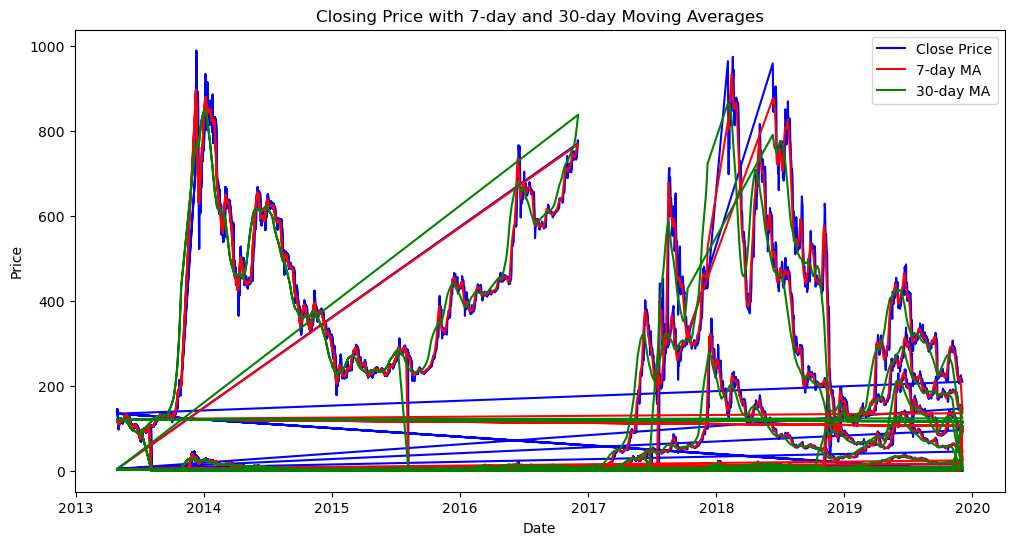

In [7]:
# Plot the closing price along with the 7-day and 30-day moving averages
plt.figure(figsize=(12, 6))
plt.plot(crypto_data['Date'], crypto_data['Close'], label='Close Price', color='blue')
plt.plot(crypto_data['Date'], crypto_data['7-day MA'], label='7-day MA', color='red')
plt.plot(crypto_data['Date'], crypto_data['30-day MA'], label='30-day MA', color='green')
plt.title('Closing Price with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
# Prepare Data for Modeling

# Define target variable (e.g., predicting next day's closing price or market fluctuation)
crypto_data['Target'] = crypto_data['Daily Return'].shift(-1)  # Predict the next day's return
crypto_data.dropna(inplace=True)  # Drop NaN values from the target column

# Define features and target
X = crypto_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap', '7-day MA', '30-day MA', 'Lag_1']]  # Fix column name here
y = crypto_data['Target']  # Target is the next day's return (positive or negative)

# Check the first few rows of the feature set
print(X.head())

        Open      High       Low     Close      Volume   Market Cap  7-day MA  \
29  0.891802  0.929289  0.877752  0.927137  13420498.0  612256490.0  1.141020   
30  0.868023  0.907127  0.864600  0.891802  16511023.0  588922638.0  1.099848   
31  0.865785  0.874167  0.848911  0.868879  11444717.0  573784519.0  1.048260   
32  0.878443  0.886302  0.857435  0.865528   9944483.0  571571532.0  0.994764   
33  0.889461  0.891029  0.863507  0.877941  12684201.0  579768933.0  0.953041   

    30-day MA     Lag_1  
29   1.216905  1.020000  
30   1.204965  0.927137  
31   1.190927  0.891802  
32   1.178445  0.868879  
33   1.166043  0.865528  


In [10]:
# Train-Test Split and Model Building

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Model Evaluation:
Mean Absolute Error (MAE): 4.4497
R-squared (R2): 0.8642


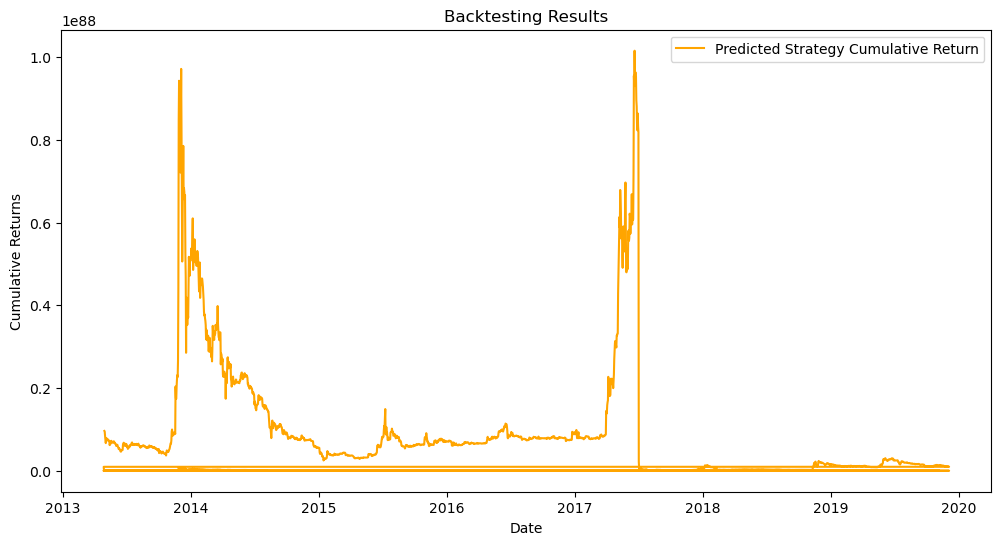

In [11]:
# Backtesting (Optional)
# Backtesting Strategy: Predicting the next day's return and applying trading logic
crypto_data['Predicted Return'] = rf_model.predict(X)

# Calculate cumulative returns using predictions
crypto_data['Cumulative Return'] = (1 + crypto_data['Predicted Return']).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(crypto_data['Date'], crypto_data['Cumulative Return'], label='Predicted Strategy Cumulative Return', color='orange')
plt.title('Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [12]:
# Save and Share Results
# Save the results to a CSV file
output_file = 'backtesting_results.csv'
crypto_data.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

Results saved to backtesting_results.csv


In [ ]:
# Limitations of the Model
# Short-Term Focus:
# The model predicts daily returns, which are influenced by short-term volatility and noise in the cryptocurrency market. It may not perform well for long-term investment strategies.
# Lack of External Factors:
# Cryptocurrency prices are affected by macroeconomic factors, regulatory news, and market sentiment (e.g., social media trends). These external factors are not included in the dataset, limiting the model's robustness.
# Limited Data Coverage:
# The dataset may only cover a specific cryptocurrency or time period, reducing the model's generalizability to other coins or market conditions.
# Overfitting Risk:
# The use of many features, such as moving averages and lagged variables, can lead to overfitting, especially if the dataset is small or unbalanced.
# Non-Stationarity:
# Cryptocurrency markets are highly dynamic and exhibit non-stationary behavior. Patterns learned by the model may not hold in future market conditions.
# Interpretability Challenges:
# Random Forest models, while accurate, lack interpretability compared to simpler models. This can be a challenge for traders who want to understand the reasoning behind predictions.
# Transaction Costs and Slippage:
# The backtesting results do not account for transaction costs or market slippage, which can significantly reduce profitability in real-world trading.
# Assumption of Efficiency:
# The model assumes that past price data contains sufficient information to predict future prices, which may not always be true due to the speculative nature of cryptocurrency markets.

# Recommendations for Improvement
# Incorporate Sentiment Analysis:
# Integrate sentiment data from social media platforms, news articles, or cryptocurrency forums to capture the impact of market sentiment on price movements.
# Use Advanced Models:
# Explore more sophisticated models like LSTMs (Long Short-Term Memory networks) or GARCH (Generalized Autoregressive Conditional Heteroskedasticity) for capturing temporal dependencies and volatility.
# Feature Selection and Dimensionality Reduction:
# Reduce the number of features using techniques like PCA (Principal Component Analysis) to minimize overfitting and improve model generalization.
# Include Macroeconomic Indicators:
# Add features such as interest rates, global financial indices, or blockchain-specific metrics (e.g., hash rates, transaction volumes) to enhance predictions.
# Evaluate Robustness:
# Test the model on different cryptocurrencies and market conditions to ensure its robustness and adaptability.
# Adjust for Transaction Costs:
# Incorporate transaction costs and slippage into the backtesting strategy to simulate real-world trading conditions.
# Dynamic Thresholding:
# Use dynamic thresholds for trading signals based on market volatility or confidence intervals to optimize decision-making.